In [1]:
source('phewas_misc.R')

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.1  
✔ tibble  2.0.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

Loading required package: latex2exp


In [3]:
annot.tbl <- '/oak/stanford/groups/mrivas/private_data/ukbb/variant_filtering/variant_filter_table.tsv.gz'
annot.arr <- read_annot_ary(annot.tbl)

In [4]:
gene_name_mapping <- compute_gene_name_mapping(annot.arr)

In [5]:
array.res.tbl <- '../cascade/sumstats.array.p1e4.tsv.gz'

In [6]:
array_df <- fread(cmd=paste0('zcat ', array.res.tbl), sep='\t', data.table=F)

In [7]:
array_df_plot <- array_df %>%
mutate(
    Code = '',
    l10pval = -log10(as.numeric(P)),
    is_biomarker_phe=TRUE
) %>% 
rename(
    Name = trait,
    LOR=BETA
) %>%
select(ID, Code, l10pval, LOR, Name, Gene_symbol, Csq, Consequence, is_biomarker_phe)


### Read GBE PheWAS results

In [65]:
phewas_dfs <- list()

In [66]:
phewas_dfs[['PTVs']] <- read_data_for_phewas_plot(
    file.path('phewas_data', 'ptvs.phewas.tsv.gz'), gene_name_mapping)
phewas_dfs[['protein-altering']] <- read_data_for_phewas_plot(
    file.path('phewas_data', 'protein-altering.phewas.tsv.gz'), gene_name_mapping)


In [67]:
for (k in names(phewas_dfs)){
    paste0(k, '. ', phewas_dfs[[k]] %>% show_dim()) %>% print()
}


[1] "PTVs. There are 2407 associations with p <= 0.000993116048420934 across 542 phenotypes and 133 variants"
[1] "protein-altering. There are 56262 associations with p <= 0.001 across 1526 phenotypes and 2978 variants"


In [68]:
phewas_dfs[['PTVs']] %>%
filter_by_code_group_and_p_and_MHC(1e-5) %>%
# left_join(annot.arr %>% select(ID, ld_indep), by='ID') %>%
# filter(ld_indep) %>%
filter(Code_group %in% c('HC', 'FH', 'cancer', 'RH')) %>%
summarize_numbers_by_lor_sign()

LOR_sign,n_associations,n_phenotypes,n_variants
negative,29,17,14
positive,24,18,14
all,53,25,27


In [69]:
phewas_dfs[['protein-altering']] %>%
filter_by_code_group_and_p_and_MHC(1e-5) %>%
left_join(annot.arr %>% select(ID, ld_indep), by='ID') %>%
filter(ld_indep) %>%
filter(Code_group %in% c('HC', 'FH', 'cancer', 'RH')) %>%
summarize_numbers_by_lor_sign()

LOR_sign,n_associations,n_phenotypes,n_variants
negative,84,34,39
positive,119,59,70
all,203,76,100


In [70]:
bind_rows(
    phewas_dfs[['PTVs']] %>%
    filter_by_code_group_and_p_and_MHC(1e-5) %>%
    filter(Code_group %in% c('HC', 'FH', 'cancer', 'RH')),
    
    phewas_dfs[['protein-altering']] %>%
    filter_by_code_group_and_p_and_MHC(1e-5) %>%
    left_join(annot.arr %>% select(ID, ld_indep), by='ID') %>%
    filter(ld_indep) %>%
    filter(Code_group %in% c('HC', 'FH', 'cancer', 'RH'))
) %>%
summarize_numbers_by_lor_sign()

LOR_sign,n_associations,n_phenotypes,n_variants
negative,113,40,53
positive,143,69,84
all,256,87,127


In [63]:
bind_rows(
    phewas_dfs[['PTVs']] %>%
    filter_by_code_group_and_p_and_MHC(1e-5) %>%
    left_join(annot.arr %>% select(ID, ld_indep), by='ID') %>%
    filter(Code_group %in% c('HC', 'FH', 'cancer', 'RH')),
    
    phewas_dfs[['protein-altering']] %>%
    filter_by_code_group_and_p_and_MHC(1e-5) %>%
    left_join(annot.arr %>% select(ID, ld_indep), by='ID') %>%
    filter(ld_indep) %>%
    filter(Code_group %in% c('HC', 'FH', 'cancer', 'RH'))
) %>%
mutate(
    GBE_variant_page = paste0('https://biobankengine.stanford.edu/variant/', gbe_variant_page_key),
    GBE_phenotype_page = paste0('https://biobankengine.stanford.edu/coding/', Code),
    Name = str_replace_all(Name, '_', ' ')
) %>%
rename(
    GBE_ID = Code,
    Variant_ID = ID,
    Variant = variant,
    log10P = l10pval,
    Phenotype = Name
) %>%
select(-Code_group, -is_biomarker_phe, -is_bin, -gbe_variant_page_key) %>%
select(
    Variant_ID, Variant, GBE_ID, Phenotype, log10P, LOR, SE, Gene_symbol, Csq, Consequence, is_outside_of_MHC, ld_indep, GBE_variant_page, GBE_phenotype_page
) %>%
fwrite(
    'phewas.tsv', sep='\t'
)

#### PTVs

In [35]:
key <- 'PTVs'
p_thr <- 1e-5

[1] "There are 551 associations with p <= 9.8627948563121e-06 across 149 phenotypes and 61 variants"
[1] "There are 826 associations with p <= 9.86281999999999e-05 across 181 phenotypes and 61 variants"


Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `y_col` joining factor and character vector, coercing into character vector”Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `x_col` joining factor and character vector, coercing into character vector”

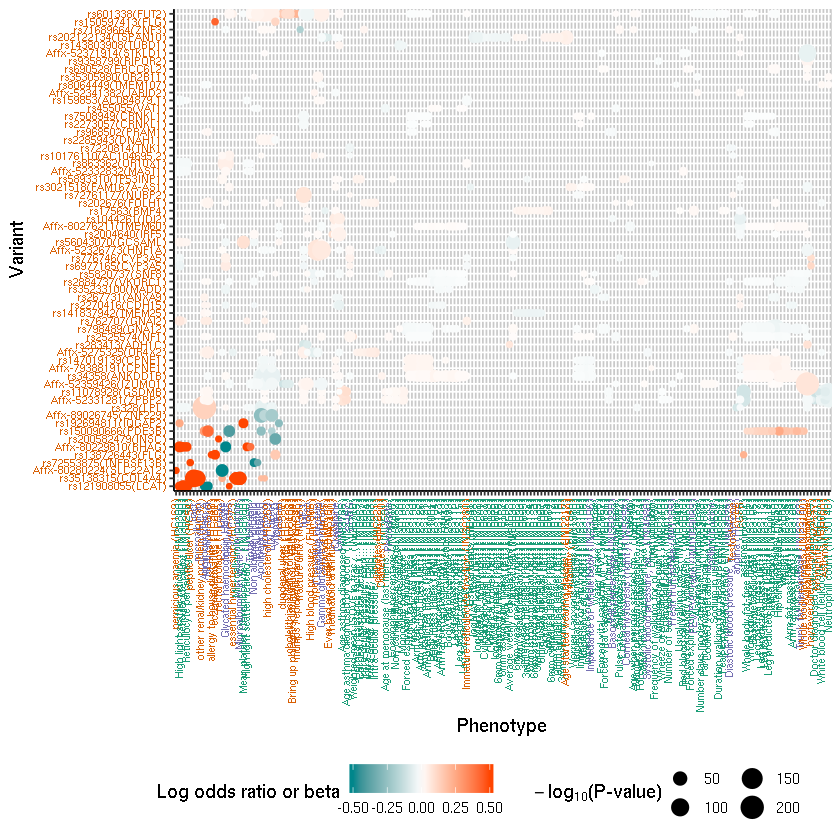

In [102]:
phewas_dfs[[key]] %>% filter_by_code_group_and_p_and_MHC(p_thr) %>%
combine_with_biomarkers(p_thr) %>%
generate_phewas_heatmap(
    axis_text_x_size = 6,
    axis_text_y_size = 6    
)


[1] "There are 116 associations with p <= 9.8627948563121e-06 across 35 phenotypes and 47 variants"
[1] "There are 345 associations with p <= 9.38545999999999e-05 across 68 phenotypes and 47 variants"


Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `y_col` joining factor and character vector, coercing into character vector”Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `x_col` joining factor and character vector, coercing into character vector”

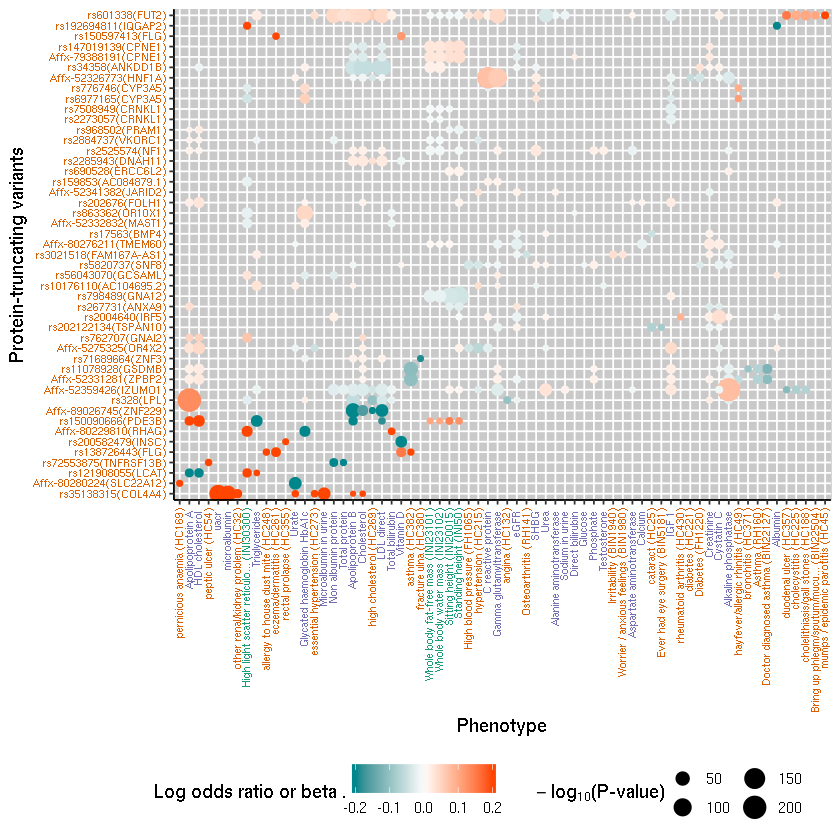

In [108]:
phewas_dfs[[key]] %>% filter_by_code_group_and_p_and_MHC(p_thr) %>%
filter(
    Code %in% (phewas_dfs[[key]] %>% 
               filter_by_code_group_and_p_and_MHC(p_thr) %>%
               filter(Code_group == 'INI') %>% count(Code) %>% 
               filter(n > 10) %>% select(Code) %>% pull()) |
    Code_group != 'INI'
) %>%
combine_with_biomarkers(p_thr) %>%
generate_phewas_heatmap(
    axis_text_x_size = 6,
    axis_text_y_size = 6,
    xlab='Phenotype',
    ylab='Protein-truncating variants',
    sizelab=TeX('-$\\log_{10}$(P-value)'),
    legend_color_title='Log odds ratio or beta . ',
    max_LOR = 0.2
) 

[1] "There are 8 associations with p <= 9.8627948563121e-06 across 7 phenotypes and 5 variants"
[1] "There are 19 associations with p <= 7.60414e-05 across 16 phenotypes and 5 variants"


Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `y_col` joining factor and character vector, coercing into character vector”Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `x_col` joining factor and character vector, coercing into character vector”

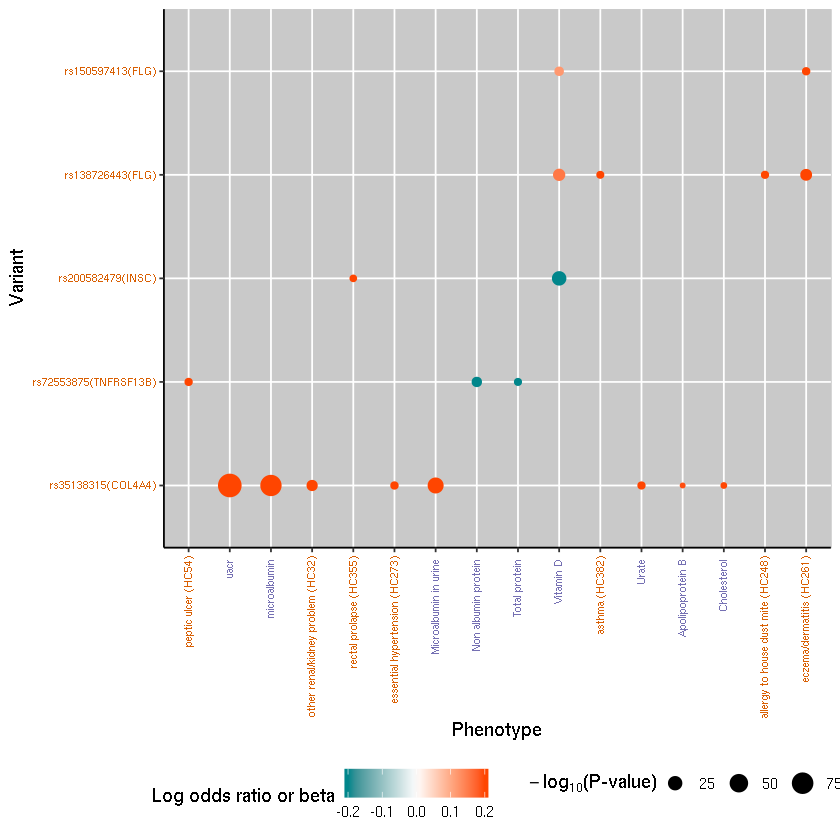

In [25]:
phewas_dfs[[key]] %>% filter_by_code_group_and_p_and_MHC(p_thr) %>%
filter(Code_group %in% c('HC', 'FH', 'cancer', 'RH')) %>%
left_join(annot.arr %>% select(ID, ld_indep), by='ID') %>%
filter(ld_indep) %>%
combine_with_biomarkers(p_thr) %>%
generate_phewas_heatmap(
    axis_text_x_size = 6,
    axis_text_y_size = 6,
    max_LOR=.2
)


[1] "There are 53 associations with p <= 9.8627948563121e-06 across 25 phenotypes and 27 variants"
[1] "There are 53 associations with p <= 9.8627948563121e-06 across 25 phenotypes and 27 variants"
[1] "There are 210 associations with p <= 9.09231e-05 across 56 phenotypes and 27 variants"


Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `y_col` joining factor and character vector, coercing into character vector”Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `x_col` joining factor and character vector, coercing into character vector”

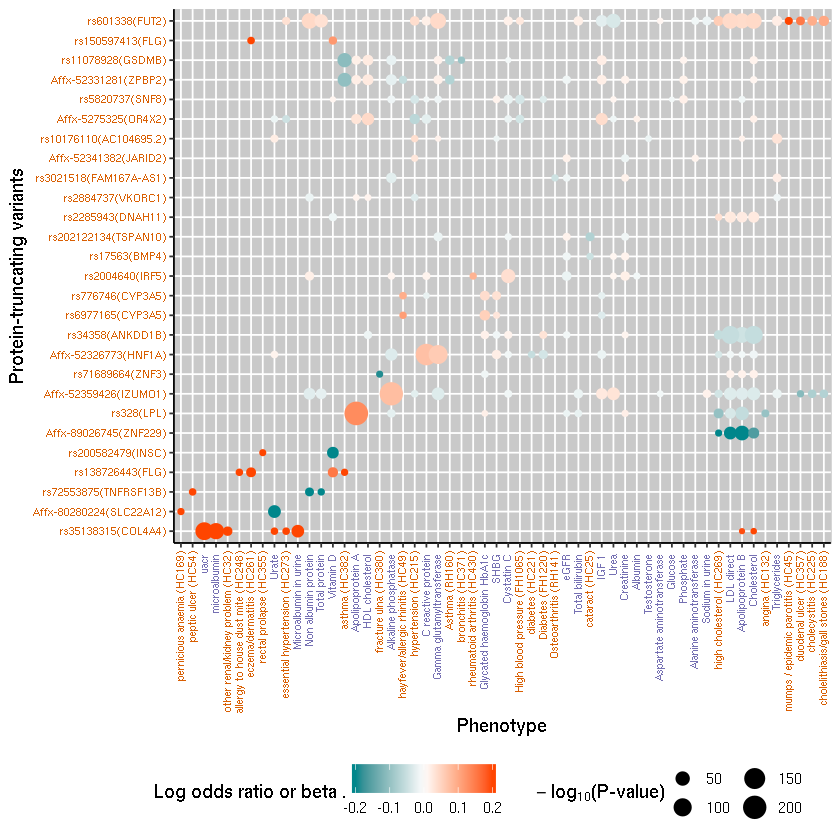

In [36]:
plot_df_tmp <- phewas_dfs[[key]] %>% filter_by_code_group_and_p_and_MHC(p_thr) %>%
filter(Code_group %in% c('HC', 'FH', 'cancer', 'RH'))

plot_df_tmp %>% show_dim() %>% print()

plot_df_tmp %>%
combine_with_biomarkers(p_thr) %>%
generate_phewas_heatmap(
    axis_text_x_size = 6,
    axis_text_y_size = 6,
    xlab='Phenotype',
    ylab='Protein-truncating variants',
    sizelab=TeX('-$\\log_{10}$(P-value)'),
    legend_color_title='Log odds ratio or beta . ',
    max_LOR = 0.2
)


In [39]:
file.path('phewas_plots', paste0('phewas.', key, '.1e', -log10(p_thr), '.png'))

[1] "phewas_plots/phewas.PTVs.1e5.png"

In [37]:
ggsave(
    file.path('phewas_plots', paste0('phewas.', key, '.1e', -log10(p_thr), '.png')),
    width=7, height=7
)


#### protein-altering

In [40]:
key <- 'protein-altering'
p_thr <- 1e-5

[1] "There are 13293 associations with p <= 1e-05 across 455 phenotypes and 1585 variants"
[1] "There are 21142 associations with p <= 9.97274e-05 across 490 phenotypes and 1585 variants"


Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `y_col` joining factor and character vector, coercing into character vector”Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `x_col` joining factor and character vector, coercing into character vector”

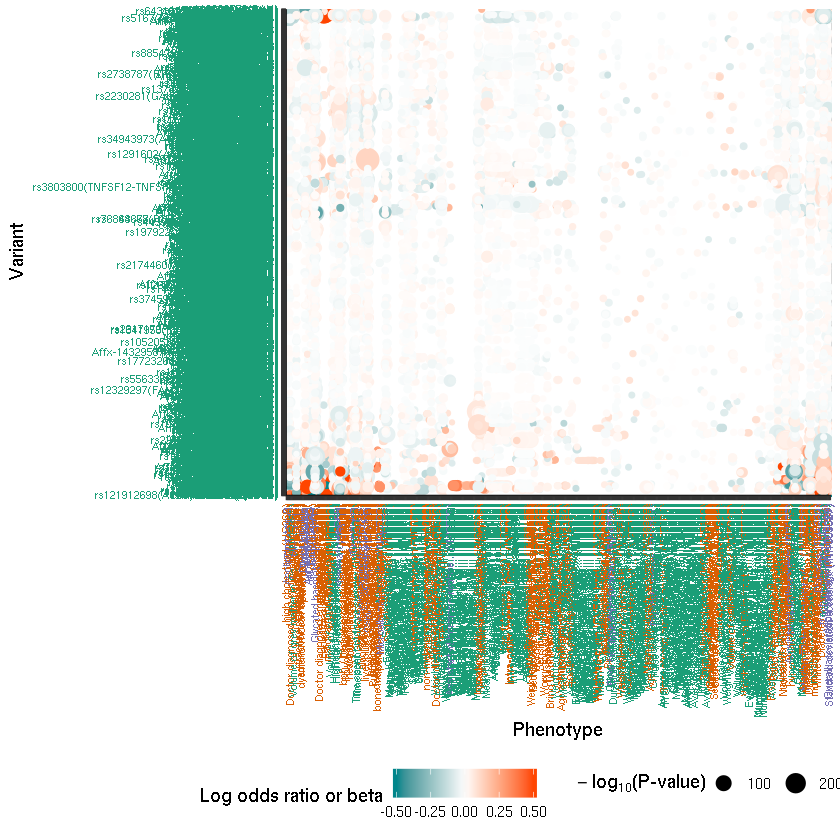

In [120]:
phewas_dfs[[key]] %>% filter_by_code_group_and_p_and_MHC(p_thr) %>%
combine_with_biomarkers(p_thr) %>%
generate_phewas_heatmap(
    axis_text_x_size = 6,
    axis_text_y_size = 6    
)

In [134]:
plot_df_tmp <- phewas_dfs[[key]] %>% filter(Code_group != 'INI') %>% 
left_join(annot.arr %>% select(ID, ld_indep), by='ID') %>%
filter(ld_indep) %>%
filter_by_code_group_and_p_and_MHC(p_thr)

plot_df_tmp <- plot_df_tmp %>%
filter(
    ID %in% (plot_df_tmp %>% count(ID) %>% top_n(30) %>% select(ID) %>% pull())
) 

plot_df_tmp <- plot_df_tmp %>%
filter(
    Code %in% (plot_df_tmp %>% count(Code) %>% top_n(20) %>% select(Code) %>% pull())
)

Selecting by n
Selecting by n


In [137]:
plot_df_tmp %>% count(Code) %>% summarise(n = min(n))

n
2


In [138]:
plot_df_tmp %>% count(ID) %>% summarise(n = min(n))

n
1


[1] "There are 203 associations with p <= 9.48418463300898e-06 across 76 phenotypes and 100 variants"


Selecting by n
Selecting by n


[1] "There are 115 associations with p <= 9.16220490121999e-06 across 30 phenotypes and 37 variants"
[1] "There are 444 associations with p <= 9.78911e-05 across 62 phenotypes and 37 variants"


Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `y_col` joining factor and character vector, coercing into character vector”Warning message in dist(.):
“NAs introduced by coercion”Warning message:
“Column `x_col` joining factor and character vector, coercing into character vector”

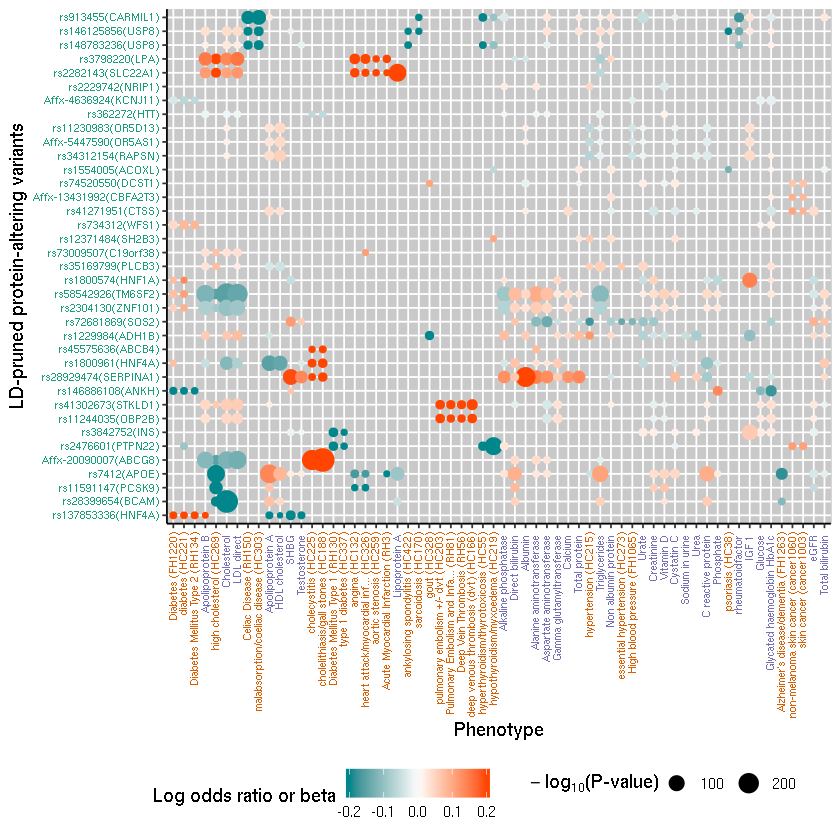

In [41]:
plot_df_tmp <- phewas_dfs[[key]] %>% 
# filter(Code_group != 'INI') %>% 
filter(Code_group %in% c('HC', 'FH', 'cancer', 'RH')) %>%
left_join(annot.arr %>% select(ID, ld_indep), by='ID') %>%
filter(ld_indep) %>%
filter_by_code_group_and_p_and_MHC(p_thr)

plot_df_tmp %>% show_dim() %>% print()

plot_df_tmp <- plot_df_tmp %>%
filter(
    ID %in% (plot_df_tmp %>% count(ID) %>% top_n(30) %>% select(ID) %>% pull())
) 

plot_df_tmp %>%
filter(
    Code %in% (plot_df_tmp %>% count(Code) %>% top_n(20) %>% select(Code) %>% pull())
) %>%
combine_with_biomarkers(p_thr) %>%
generate_phewas_heatmap(
    axis_text_x_size = 6,
    axis_text_y_size = 6,
    xlab='Phenotype',
    ylab='LD-pruned protein-altering variants',
    max_LOR = 0.2    
)


In [43]:
file.path('phewas_plots', paste0('phewas.', key, '.1e', -log10(p_thr), '.png'))

[1] "phewas_plots/phewas.protein-altering.1e5.png"

In [42]:
ggsave(
    file.path('phewas_plots', paste0('phewas.', key, '.1e', -log10(p_thr), '.png')),
    width=7, height=7
)
